In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_predict, GridSearchCV, learning_curve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_set = pd.DataFrame(pd.read_csv('train.csv'))
train_set.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

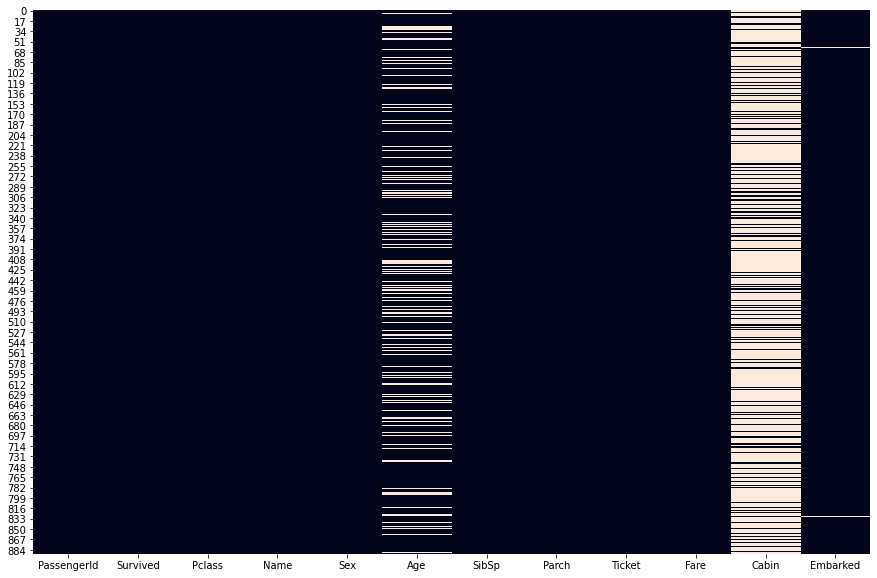

In [3]:
plt.figure(figsize=(15,10))
sns.heatmap(train_set.isna(), cbar=False)

In [4]:
train_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


The 'Survived', 'Pclass', 'Name', 'Sex', and 'Embarked' are all categorical attributes of the dataset.

<AxesSubplot:xlabel='Sex', ylabel='count'>

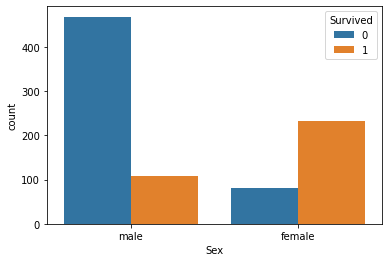

In [5]:
sns.countplot(data=train_set, x='Sex', hue='Survived')

Clearly more males died than females as well as females were more likely to survive than males

<AxesSubplot:xlabel='Pclass', ylabel='count'>

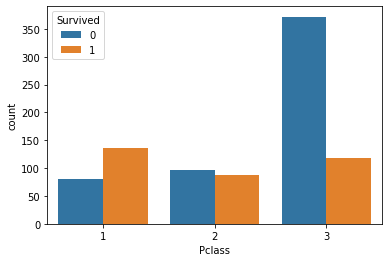

In [6]:
sns.countplot(data=train_set, x='Pclass', hue='Survived')

Seems that the first class was most likely to survive, even though the count of survived passengers is close between classes

/home/bananashoes/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare'>

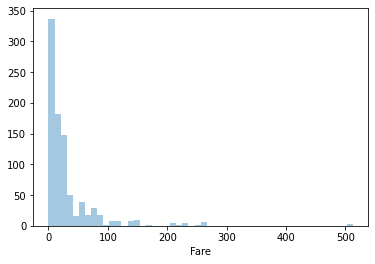

In [7]:
sns.distplot(train_set['Fare'], kde=False)

Seems most of the tickets where under 50 bucks per person, with a few high cost tickets

<AxesSubplot:xlabel='Age'>

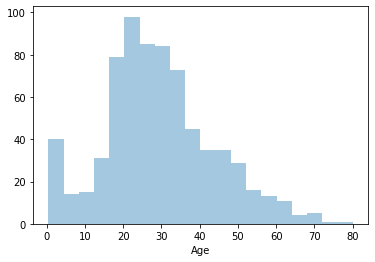

In [8]:
sns.distplot(train_set[train_set.notnull()]['Age'], kde=False)

Seems there were a majority of people around 20-35, with a surprisingly large amount of 0-5 year olds

In [9]:
pclass_median_age = train_set.groupby('Pclass')['Age'].median()
pclass_median_age

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

Text(0.5, 0, 'Pclass')

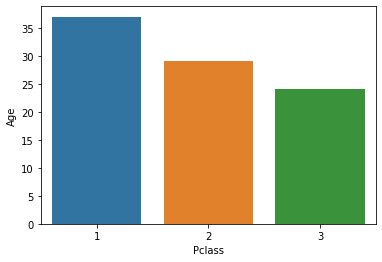

In [10]:
sns.barplot(x=sorted(train_set['Pclass'].unique()), y=pclass_median_age.values)
plt.ylabel('Age')
plt.xlabel('Pclass')

In [11]:
train_set = train_set.drop('Cabin', axis=1)

In [12]:
def impute_age(df):
    ages = train_set.groupby('Pclass')['Age'].median()
    if df.isna().any():
        df['Age'] = ages[df['Pclass']]
    return df
    
train_set['Age'] = train_set[['Age','Pclass']].apply(impute_age, axis=1)['Age']

In [13]:
train_set = train_set.dropna()
train_set.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [14]:
#'Survived' and 'Pclass' are already numerical, 'Name' has not meaning for being numerical
dummies = pd.get_dummies(train_set[['Sex', 'Embarked']])
train_set = train_set.join(dummies)
train_set = train_set.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'PassengerId'], axis=1)
train_set

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,24.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [15]:
feature_set = train_set.drop('Survived', axis=1)
label_set = train_set['Survived'].copy()
feature_set

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,19.0,0,0,30.0000,1,0,0,0,1
888,3,24.0,1,2,23.4500,1,0,0,0,1
889,1,26.0,0,0,30.0000,0,1,1,0,0


In [16]:
lr = LogisticRegression(solver='liblinear').fit(feature_set, label_set)
lr_pred = lr.predict(feature_set)

In [17]:
svm = SVC().fit(feature_set, label_set)
svm_pred = svm.predict(feature_set)

In [18]:
sgd_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('SGDClassifier', SGDClassifier())
])
sgd_clf.fit(feature_set, label_set)
sgd_pred = sgd_clf.predict(feature_set)

In [19]:
print(classification_report(label_set, lr_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.69      0.73       340

    accuracy                           0.81       889
   macro avg       0.80      0.78      0.79       889
weighted avg       0.80      0.81      0.80       889



In [20]:
print(classification_report(label_set, svm_pred))

              precision    recall  f1-score   support

           0       0.68      0.92      0.78       549
           1       0.71      0.31      0.43       340

    accuracy                           0.69       889
   macro avg       0.69      0.61      0.61       889
weighted avg       0.69      0.69      0.65       889



In [21]:
print(classification_report(label_set, sgd_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       549
           1       0.77      0.56      0.65       340

    accuracy                           0.77       889
   macro avg       0.77      0.73      0.74       889
weighted avg       0.77      0.77      0.76       889



In [22]:
print(confusion_matrix(label_set, lr_pred))

[[480  69]
 [104 236]]


In [23]:
print(confusion_matrix(label_set, svm_pred))

[[506  43]
 [236 104]]


In [24]:
print(confusion_matrix(label_set, sgd_pred))

[[491  58]
 [149 191]]


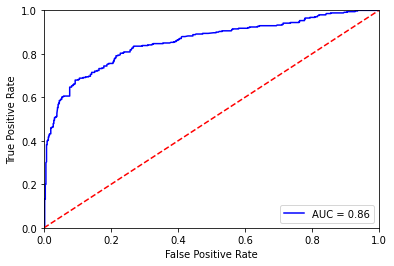

In [25]:
lr_probs = lr.predict_proba(feature_set)
lr_preds = lr_probs[:,1]

lr_fpr, lr_tpr, lr_threshold = roc_curve(label_set, lr_preds)
lr_roc_auc = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, 'b', label='AUC = %0.2f'%lr_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


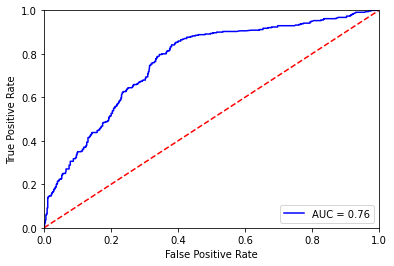

In [26]:
svm_probs = svm.decision_function(feature_set)

svm_fpr, svm_tpr, svm_threshold = roc_curve(label_set, svm_probs)
svm_roc_auc = auc(svm_fpr, svm_tpr)
plt.plot(svm_fpr, svm_tpr, 'b', label='AUC = %0.2f'%svm_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

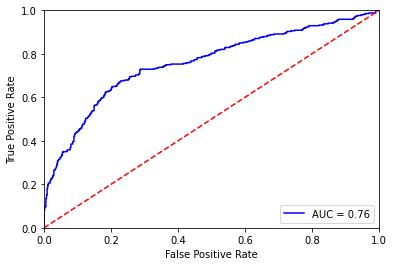

In [27]:
sgd_probs = cross_val_predict(sgd_clf, feature_set, label_set, cv=10, method='decision_function')

sgd_fpr, sgd_tpr, sgd_threshold = roc_curve(label_set, sgd_probs)
sgd_roc_auc = auc(sgd_fpr, sgd_tpr)
plt.plot(sgd_fpr, sgd_tpr, 'b', label='AUC = %0.2f'%sgd_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', SVC())
])

param_grid = [{'linear_svc__kernel': ['rbf'], 'linear_svc__gamma': [0.0001, 0.001,
0.01, 0.1, 1], 'linear_svc__C': [1,10,50,100,200,300]}]
grid_search = GridSearchCV(svm_clf, param_grid)
grid_search.fit(feature_set, label_set)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('linear_svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                           

In [29]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 SVC(C=50, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [30]:
grid_search.best_params_

{'linear_svc__C': 50, 'linear_svc__gamma': 0.01, 'linear_svc__kernel': 'rbf'}

In [31]:
grid_search.best_score_

0.8245730971878373

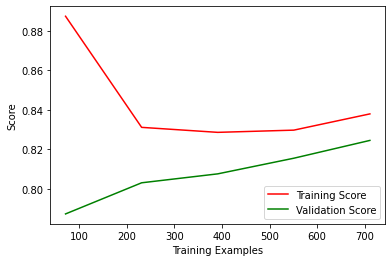

In [32]:
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, feature_set, label_set)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, color='g', label='Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc = 'lower right')
plt.show()

Seems as the training examples increased, the training score decreases then slightly increases at the end while the validation score increases slightly. The lines being fairly close to each other demonstrates the model is a good estimator for the trained and unseen data with a slight preference to the unseen data having a positive trend in predictive power as training examples increase